In [4]:

import os, sys
sys.path.append(os.getcwd())
sys.path.append(os.getcwd()+"/FlexModEHC/")

import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter

from generators import Generator
from propagators import Propagator
from explorers import Explorer
from environments import LinearTrack, TJunction, OpenBox
from autocorrelation import (
    zcf_gen,
    zcf_sum,
    acf_gen,
    acf_sum,
    constraints_stochmat,
    bounds_statdist,
)

import complextools

 <font size="10">LinearTrack</font> 

GENERATOR: generator constructed from environment adjacency matrix with jump_rate 1.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is symmetric.
GENERATOR: Q is a generator with shape (10, 10) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 1


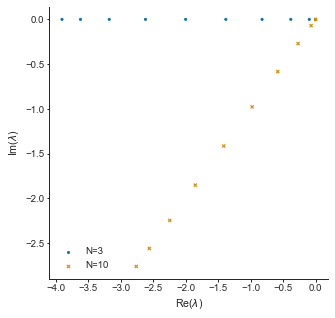

In [5]:
#LinearTrack
%matplotlib inline

n_state = 10
goal = None
jump_rate = 1.
forward = True
symmetrize=False
#spectrum comparison: rotation
ENV = LinearTrack(scale=n_state, goal=goal)
GEN = Generator(ENV=ENV, forward=forward, symmetrize=symmetrize, jump_rate=jump_rate)
PROP = Propagator(GEN=GEN)
L = PROP.GEN.evals_fwd.copy();

counter = Counter(L)
uniqueL = np.array(list(counter.keys()))
multipL = np.array(list(counter.values()))
fig = plt.figure(figsize=(5,5))
plt.scatter(uniqueL.real, uniqueL.imag, s=5**multipL, label="N=3")
plt.xlabel("Re($\lambda$)")
plt.ylabel("Im($\lambda$)")

#rotating eigenvalues by $\varphi$
phi = np.pi/4
uniqueM = complextools.rotate(uniqueL, phi, c=0)
plt.scatter(uniqueM.real, uniqueM.imag, s=10**multipL, label="N=10", marker="x")
plt.xlabel("Re($\lambda$)")
plt.ylabel("Im($\lambda$)")

plt.legend()

 <font size="5">Simulation</font> 

In [8]:
rotated_L = complextools.rotate(L, phi, c=0)
V = PROP.GEN.EVEC_fwd
Vinv = PROP.GEN.EVECinv_fwd
etO = complextools.calculate_etO(power_spec=rotated_L, V=V, Vinv=Vinv, tau=1, alpha=1, t=1, sigma=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


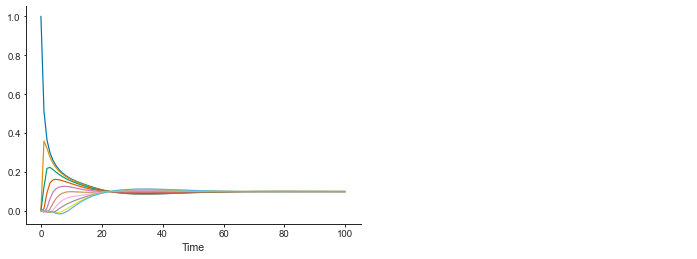

In [10]:
#Simulation for different rotations of the eigenspectra
T = 100
rho0 = np.zeros(n_state)
rho0[0] = 1
rhos = complextools.simulate(etO, T, rho0)
    
plt.plot(rhos)
plt.xlabel("Time")
plt.ylabel("")
plt.legend(loc='best', bbox_to_anchor=(1, 0., 1, 1))
plt.show()

<font size="5">ACF</font> 

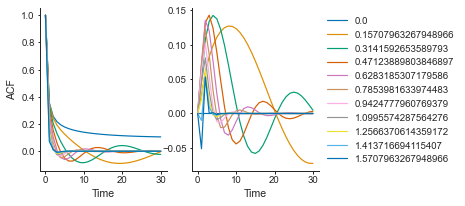

In [11]:
#ACF/ZFC dependent on rotation of eigenvalues
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
alpha=1
tau=1
L = PROP.GEN.evals_fwd.copy();
Gamma = GEN.spectral_matrix()
T_steps = 30
deltaT = np.linspace(0,T_steps,T_steps+1)
phis = np.linspace(0,np.pi/2,11)
for phi in phis:
    L_rotated = complextools.rotate(L, phi, c=1)
    s = np.exp(L_rotated**alpha/tau)
    auto_corr = zcf_gen(s, Gamma, deltaT, rho0)
    # extract real part
    x = [ele.real for ele in auto_corr]
    # extract imaginary part
    y = [ele.imag for ele in auto_corr]
    axes[0].plot(x)
    axes[1].plot(y, label=str(phi))
    axes[1].legend(loc='best', bbox_to_anchor=(1, 0., 1, 1))
#     plt.plot(auto_corr)
axes[0].set_ylabel("ACF")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")

plt.show()

<font size="5">Sampling</font> 

In [ ]:
# SETTINGS - EXPLORER
n_step = 75
n_samp = 20
target_coverage = 0.5
flight_vision = True

start_prop = 0
# no_dwell_pfeiffer?
no_dwell = False
no_dwell_pfeiffer = True

# parallel explorer
EXP_diff_base = Explorer(PROP=PROP, rho_init=start_prop, label='diffusion')

# serial explorer
EXP_diff_oneshot = Explorer(PROP=PROP, rho_init=start_prop, label='diffusion')

EXP_diff_base.sample_sequences(n_samp=n_samp, n_step=n_step)
# EXP_sdiff_base.sample_sequences(n_samp=n_samp, n_step=n_step)
EXP_diff_base.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)
# EXP_sdiff_base.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)

EXP_diff_oneshot.sample_sequences(n_samp=1, n_step=n_step)
# EXP_sdiff_oneshot.sample_sequences(n_samp=1, n_step=n_step)
EXP_diff_oneshot.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)
# EXP_sdiff_oneshot.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)

SIMULATOR.sequences_to_paths: paths truncated to minimum length of 99.
SIMULATOR.sequences_to_paths: paths truncated to minimum length of 102.


In [13]:
# sample many more trajectories to roughly match # trajectory events in Pfeiffer & Foster (2015)
n_samp_mult = 25
EXP_diff_base_LARGESCALE = Explorer(PROP=PROP, rho_init=start_prop, no_dwell=no_dwell_pfeiffer, label='diffusion')
# EXP_sdiff_base_LARGESCALE = Explorer(PROP=PROP_sdiff_base, rho_init=start_prop, no_dwell=no_dwell_pfeiffer, label='superdiffusion')
EXP_diff_base_LARGESCALE.sample_sequences(n_samp=n_samp*n_samp_mult, n_step=n_step)
# EXP_sdiff_base_LARGESCALE.sample_sequences(n_samp=n_samp*n_samp_mult, n_step=n_step)
EXP_diff_base_LARGESCALE.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)
# EXP_sdiff_base_LARGESCALE.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)

SIMULATOR.sequences_to_paths: paths truncated to minimum length of 92.


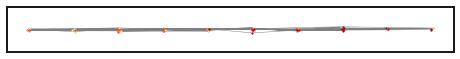

In [14]:
cmap_samp = 'colorblind'
traj_width = 0.5
EXP_diff_oneshot.cmap_samp = cmap_samp
EXP_diff_oneshot.traj_width = traj_width
EXP_diff_oneshot.plot_trajectory()

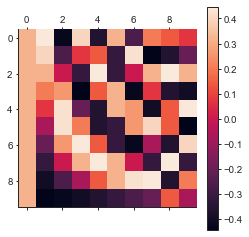

In [15]:
plt.matshow(EXP_diff_oneshot.GEN.EVEC)
plt.colorbar();

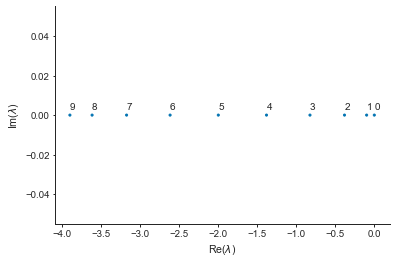

In [23]:
counter = Counter(L)
uniqueL = np.array(list(counter.keys()))
multipL = np.array(list(counter.values()))
fig, ax = plt.subplots()
ax.scatter(uniqueL.real, uniqueL.imag, s=5**multipL, label="")
ax.set_xlabel("Re($\lambda$)")
ax.set_ylabel("Im($\lambda$)")
for i in range(n_state):
    ax.annotate(str(i), (uniqueL.real[i], .003))

 <font size="10">TJunction</font> 

In [16]:
backflow = 0.1 # 0.1
state_start = 23 # 23/26
rho0 = state_start
alpha = 1.
env_lw = 1.

# SETTINGS - GENERATOR
symmetrize = False
jump_rate = 0.5

# SETTINGS - PROPAGATOR
sigma = 1.
tau = 1. # 1.
alpha_diff = 1
alpha_sdiff = 0.5
# ENVIRONMENT
ENV = TJunction(start=state_start, directed=True, complete_circuit=False, backflow=backflow)
rho_rand = np.ones((ENV.n_state,))/ENV.n_state
ENV.env_lw = env_lw
n_state = ENV.n_state

# GENERATOR
GEN = Generator(ENV=ENV, symmetrize=symmetrize, jump_rate=jump_rate)
rho_inf = GEN.stationary_dist()

# PROPAGATOR
PROP = Propagator(GEN=GEN, sigma=sigma, tau=tau, alpha=alpha_diff)

GENERATOR: generator constructed from environment transition matrix with jump_rate 0.50
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is not symmetric.
GENERATOR: Q is a generator with shape (28, 28) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 2
EIGENSPECTRUM: algebraic multiplicity > 1.


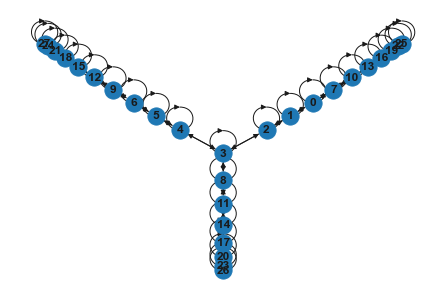

In [17]:
#show generator of TJuction as a graph
DG = nx.from_numpy_array(GEN.Q, create_using=nx.DiGraph)
pos = nx.spectral_layout(DG)
nx.draw(DG, pos=pos, with_labels=True, font_weight='bold') 
plt.show()

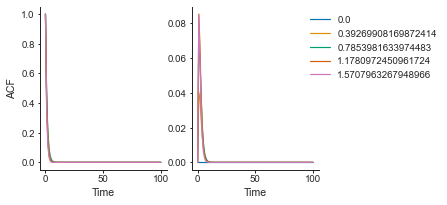

In [21]:
#ACF/ZFC dependent on rotation of eigenvalues
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
tau=1.
rho0 = np.zeros(n_state)
rho0[0] = 1
L = PROP.GEN.evals_fwd.copy();
Gamma = GEN.spectral_matrix()
T_steps = 100
deltaT = np.linspace(0,T_steps,T_steps+1)
phis = np.linspace(0,np.pi/2,5)
for phi in phis:
    L_rotated = complextools.rotate(L, phi, c=1)
    s = np.exp(L_rotated**alpha/tau)
    auto_corr = zcf_gen(s, Gamma, deltaT, rho0)
    # extract real part
    x = [ele.real for ele in auto_corr]
    # extract imaginary part
    y = [ele.imag for ele in auto_corr]
    axes[0].plot(x)
    axes[1].plot(y, label=str(phi))
    axes[1].legend(loc='best', bbox_to_anchor=(1, 0., 1, 1))
#     plt.plot(auto_corr)
axes[0].set_ylabel("ACF")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")

plt.show()

 <font size="10">OpenBox</font> 

GENERATOR: generator constructed from environment adjacency matrix with jump_rate 0.50
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is symmetric.
GENERATOR: Q is a generator with shape (100, 100) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 1
EIGENSPECTRUM: algebraic multiplicity > 1.


Text(0, 0.5, 'Im($\\lambda$)')

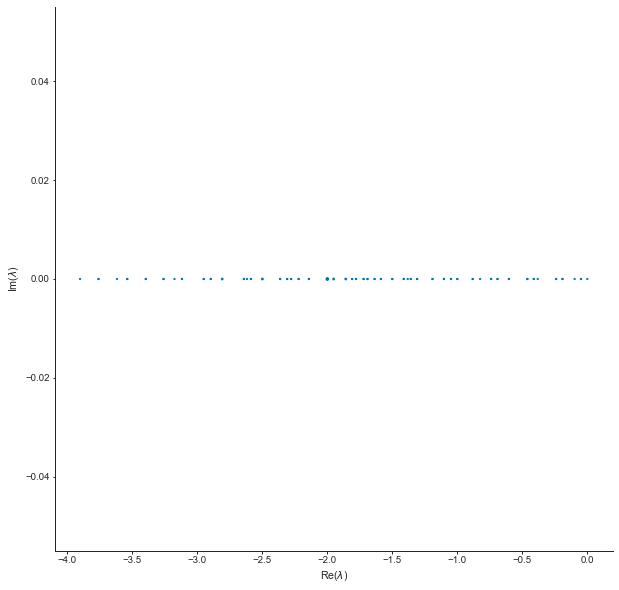

In [22]:
scale = 10 # 50

# SETTINGS - PROPAGATOR
sigma = 1.
tau_diff = 1.
tau_sdiff = 1.
n_tau = 2; taus = np.logspace(0.1,10,n_tau)
alpha_diff = 1.
alpha_sdiff = 0.5
no_dwell = False
no_dwell_pfeiffer = True

# SAMPLING
ENV = OpenBox(scale=scale)
start_prop = ENV.start_center

GEN = Generator(ENV=ENV, forward=forward, symmetrize=symmetrize, jump_rate=jump_rate)

PROP_diff_base = Propagator(GEN=GEN, sigma=sigma, tau=tau_diff, alpha=alpha_diff)

#spectrum
L = PROP_diff_base.GEN.evals_fwd.copy();
counter = Counter(L)
uniqueL = np.array(list(counter.keys()))
multipL = np.array(list(counter.values()))

fig = plt.figure(figsize=(10,10))
plt.scatter(uniqueL.real, uniqueL.imag, s=2**multipL, label="N=3")
plt.xlabel("Re($\lambda$)")
plt.ylabel("Im($\lambda$)")

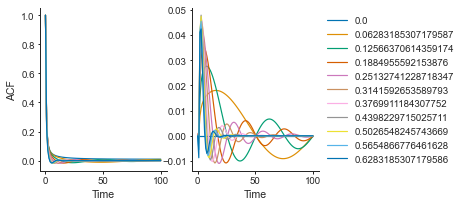

In [24]:
#ACF/ZFC dependent on rotation of eigenvalues
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
tau=1.
L = PROP_diff_base.GEN.evals_fwd.copy();
n_state = L.shape[0]
rho0 = np.zeros(n_state)
rho0[0] = 1
Gamma = GEN.spectral_matrix()
T_steps = 100
deltaT = np.linspace(0,T_steps,T_steps+1)
phis = np.linspace(0,np.pi/5,11)
for phi in phis:
    L_rotated = complextools.rotate(L, phi, c=1)
    s = np.exp(L_rotated**alpha/tau)
    auto_corr = zcf_gen(s, Gamma, deltaT, rho0)
    # extract real part
    x = [ele.real for ele in auto_corr]
    # extract imaginary part
    y = [ele.imag for ele in auto_corr]
    axes[0].plot(x)
    axes[1].plot(y, label=str(phi))
    axes[1].legend(loc='best', bbox_to_anchor=(1, 0., 1, 1))
#     plt.plot(auto_corr)
axes[0].set_ylabel("ACF")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")

plt.show()

<font size="5">Sampling</font> 

In [25]:
# SETTINGS - EXPLORER
n_step = 75
n_samp = 20
target_coverage = 0.5
flight_vision = True

# parallel explorer
EXP_diff_base = Explorer(PROP=PROP_diff_base, rho_init=start_prop, no_dwell=no_dwell, label='diffusion')

# serial explorer
EXP_diff_oneshot = Explorer(PROP=PROP_diff_base, rho_init=start_prop, no_dwell=no_dwell, label='diffusion')

EXP_diff_base.sample_sequences(n_samp=n_samp, n_step=n_step)
# EXP_sdiff_base.sample_sequences(n_samp=n_samp, n_step=n_step)
EXP_diff_base.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)
# EXP_sdiff_base.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)

EXP_diff_oneshot.sample_sequences(n_samp=1, n_step=n_step)
# EXP_sdiff_oneshot.sample_sequences(n_samp=1, n_step=n_step)
EXP_diff_oneshot.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)
# EXP_sdiff_oneshot.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)

SIMULATOR.sequences_to_paths: paths truncated to minimum length of 69.
SIMULATOR.sequences_to_paths: paths truncated to minimum length of 97.


In [26]:
# sample many more trajectories to roughly match # trajectory events in Pfeiffer & Foster (2015)
n_samp_mult = 25
EXP_diff_base_LARGESCALE = Explorer(PROP=PROP_diff_base, rho_init=start_prop, no_dwell=no_dwell_pfeiffer, label='diffusion')
# EXP_sdiff_base_LARGESCALE = Explorer(PROP=PROP_sdiff_base, rho_init=start_prop, no_dwell=no_dwell_pfeiffer, label='superdiffusion')
EXP_diff_base_LARGESCALE.sample_sequences(n_samp=n_samp*n_samp_mult, n_step=n_step)
# EXP_sdiff_base_LARGESCALE.sample_sequences(n_samp=n_samp*n_samp_mult, n_step=n_step)
EXP_diff_base_LARGESCALE.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)
# EXP_sdiff_base_LARGESCALE.compute_diagnostics(target_coverage=target_coverage, flight_vision=flight_vision)

SIMULATOR.sequences_to_paths: paths truncated to minimum length of 104.


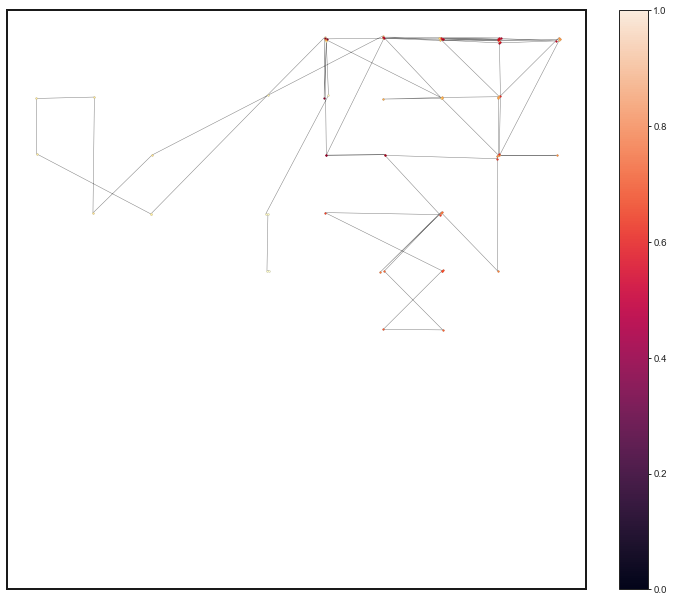

In [27]:
from visualization import save_figure, color_diff, color_superdiff, label_panel, page_width, row_height
width = page_width*1.3
height = row_height*3
widths = [1,1,1,1]
heights = [1,1,1]
alpha_base = 1.
alpha_shift = 0.5
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(width, height), constrained_layout=True) 
# gridspec_kw={'width_ratios':widths, 'height_ratios':heights}
cmap_prop = {alpha_shift:color_superdiff, alpha_base:color_diff} # cm.cool_rq
ax0 = axes
cmap_samp = 'colorblind'
traj_width = 0.5
EXP_diff_oneshot.cmap_samp = cmap_samp
EXP_diff_oneshot.traj_width = traj_width
EXP_diff_oneshot.set_target_axis(ax=ax0)
EXP_diff_oneshot.plot_trajectory()

samp=0
coords = EXP_diff_base._retrieve_state(samp=samp, step=None, coords=True)
x = coords[:,0]
y = coords[:,1]
colors = EXP_diff_base.cmap_traj(np.linspace(0, 1, EXP_diff_base.max_steps))
for xs, ys, c in zip(x, y, colors):
    sc = ax0.scatter(xs, ys, color=c, edgecolor='k', s=0, linewidth=EXP_diff_base.state_lw, zorder=102)
# sc = plt.scatter()
plt.colorbar(sc)

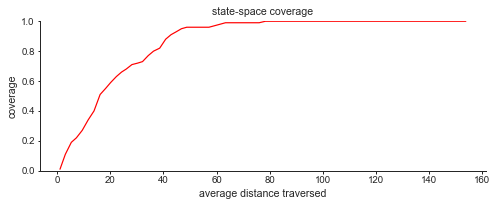

In [28]:
EXP_diff_base.plot_coverage(color=color_diff, func_of_time=False)